<div style="text-align:center">
    <img src="https://images.unsplash.com/photo-1537144054285-546dd123f77d?q=80&w=2497&auto=format&fit=crop&ixlib=rb-4.0.3&ixid=M3wxMjA3fDB8MHxwaG90by1wYWdlfHx8fGVufDB8fHx8fA%3D%3D" width="400"/>
</div>

---


# Project Overview: Generating X-ray Hand Images using a Variational Autoencoder

This project explores the application of a Variational Autoencoder (VAE) for generating X-ray images of hands. Such synthetic images have potential uses in medical imaging studies, training radiologists, and enhancing machine learning models in healthcare.

### Understanding VAEs and GANs
In the realm of image generation, two prominent techniques are Variational Autoencoders (VAEs) and Generative Adversarial Networks (GANs). VAEs are known for their efficiency in training and ability to produce diverse results, while GANs are often celebrated for generating high-quality images.

### Why Choose a VAE?
For this project, a VAE was chosen due to several considerations:
- **Training Efficiency**: VAEs generally require less training time and resources, making them suitable for our dataset of 8000 images.
- **Quality vs. Detail Trade-off**: In the context of X-ray images, ultra-high-definition detail is not always paramount. While VAEs may not produce images as sharp as those from GANs, they offer a satisfactory level of detail for X-ray imagery, balancing quality with computational efficiency.

By focusing on these aspects, this project aims to demonstrate the capabilities of VAEs in generating useful synthetic medical images, contributing to the broader field of AI in medical imaging.


## Data Preparation

For this project, I utilized a dataset of hand X-ray images given in my assignment. The dataset comprises 8000 images, offering a substantial amount of data for training the Variational Autoencoder.

### Importing Necessary Libraries and Setting Up

In [1]:
# Standard library imports
import os
import sys

# Third-party library imports
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
from livelossplot import PlotLosses

# Local module imports
sys.path.append('../src')  # Adjust the path according to your notebook's location
from data_loader import create_data_loaders 
from train_vae import train, validate
from utils import set_device
from vae_model import VAE, vae_loss


In [2]:
# Set the device
device = set_device()

# Create data loaders
image_dir = '../data/real_hands'
train_loader, test_loader = create_data_loaders(image_dir)  # Create data loaders

#### Resizing Images for Optimal Feature Capture
In the initial phase of data preparation, I decided to resize the images to 64x64 pixels. This decision was driven by the intention to capture more features without significantly increasing the computational load. Image resolution plays a crucial role in model training; higher resolutions can offer more detail but may introduce complexity and require more computational resources.

#### Evaluating Different Image Resolutions
To find the optimal balance,I experimented with both 64x64 and the standard 32x32 pixel resolutions. This experimentation aimed to assess whether the increased resolution would lead to better model performance or if the standard size would suffice. After a preliminary test over 10 epochs, it was observed that the standard image size of 32x32 pixels performed better in terms of loss metrics, offering a more efficient training process without compromising the model's ability to learn relevant features.

### Data Loading and Inspection

Once the data loaders are set up, it is essential to understand the characteristics of the dataset. This understanding will help in making informed decisions throughout the model development process.

Batch size: 64
Number of batches: 100
Total number of images: 6400
Image shape: torch.Size([64, 1, 32, 32])


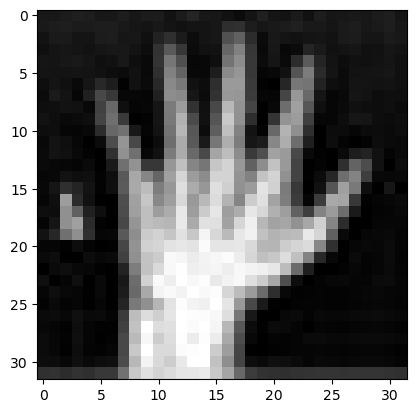

Number of pixels in each image: 1024
Pixel value range: max, 1.0 min, -1.0


In [3]:
print("Batch size:", train_loader.batch_size)
print("Number of batches:", len(train_loader))
print("Total number of images:", train_loader.batch_size * len(train_loader))

# Retrieve the first batch of images
images = next(iter(train_loader))

print("Image shape:", images.shape)  # Shape is [batch_size, n_channels, height, width]

# Plot the first image in the batch
plt.imshow(images[0].squeeze(), cmap='gray')
plt.show()

# Number of pixels in the image
print("Number of pixels in each image:", images.shape[2] * images.shape[3])

# Range of pixel values
print("Pixel value range: max,", images.max().item(), "min,", images.min().item())

## Network design and implementation

#### Hyperparameter Tuning
For the training of the VAE, I utilised the best hyperparameters identified through an extensive grid search. This process was conducted within the constraints of the available computational resources and time for the assigment, ensuring a thorough exploration of the parameter space.

#### Network Enhancements
In the network design, convolutional layers were added to both the encoder and decoder. This addition aims to enhance the model's ability to learn spatial features effectively, crucial for accurate image generation.

#### Training Techniques and Loss Function
The model employs the reparameterization trick, a technique pivotal in variational inference, to facilitate more efficient training. For the loss function, we opted for a combination of Mean Squared Error (MSE) and Kullback-Leibler (KL) divergence. This choice balances the model's ability to accurately reconstruct images while effectively learning the underlying data distribution.

#### Future Improvement Plans
Looking ahead, there are several avenues for potential improvements:
- **Adding Batch Normalization**: This could enhance training stability and speed.
- **Exploring Alternative Loss Functions**: Investigating loss functions like binary cross-entropy might yield improvements in image quality.
- **Monitoring Loss Components**: A more detailed analysis of the individual loss components could provide deeper insights into the model's learning dynamics.

Regular visualization of reconstructed images is planned to continuously assess and guide the model's performance throughout the training process.

#### Insights from Preliminary Testing
Initial experiments, including a short test run of 10 epochs, indicated that reducing the spatial dimension to 2x2 resulted in lower test loss and faster training. These findings suggest a trade-off between model complexity and efficiency. Further exploration of different latent space dimensions, such as comparing 4x4 and 2x2, is part of our ongoing hyperparameter tuning efforts, aiming to refine the model's performance.


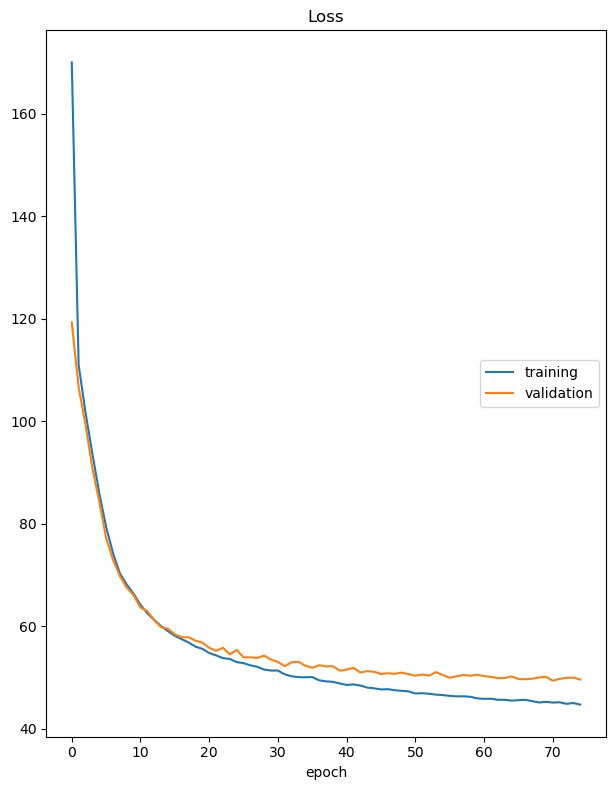

Loss
	training         	 (min:   44.723, max:  169.958, cur:   44.723)
	validation       	 (min:   49.393, max:  119.266, cur:   49.617)


In [4]:
liveloss = PlotLosses()

# Instantiate the model
vae = VAE().to(device)

# Initialize the optimizer
optimizer = optim.Adam(vae.parameters(), lr=1e-3)

num_epochs = 75

for epoch in range(1, num_epochs + 1):
    train_loss = train(vae, device, train_loader, optimizer)
    val_loss = validate(vae, device, test_loader)

    # Update the livelossplot with current loss values
    liveloss.update({
        'loss': train_loss,
        'val_loss': val_loss
    })

    # Render the plot
    liveloss.send()



### Visual Comparison with Test Set
To assess the quality of our generated images, we compare them with actual images from the test set. This comparison provides a visual benchmark to evaluate how well the model can reconstruct and generate new, realistic images.

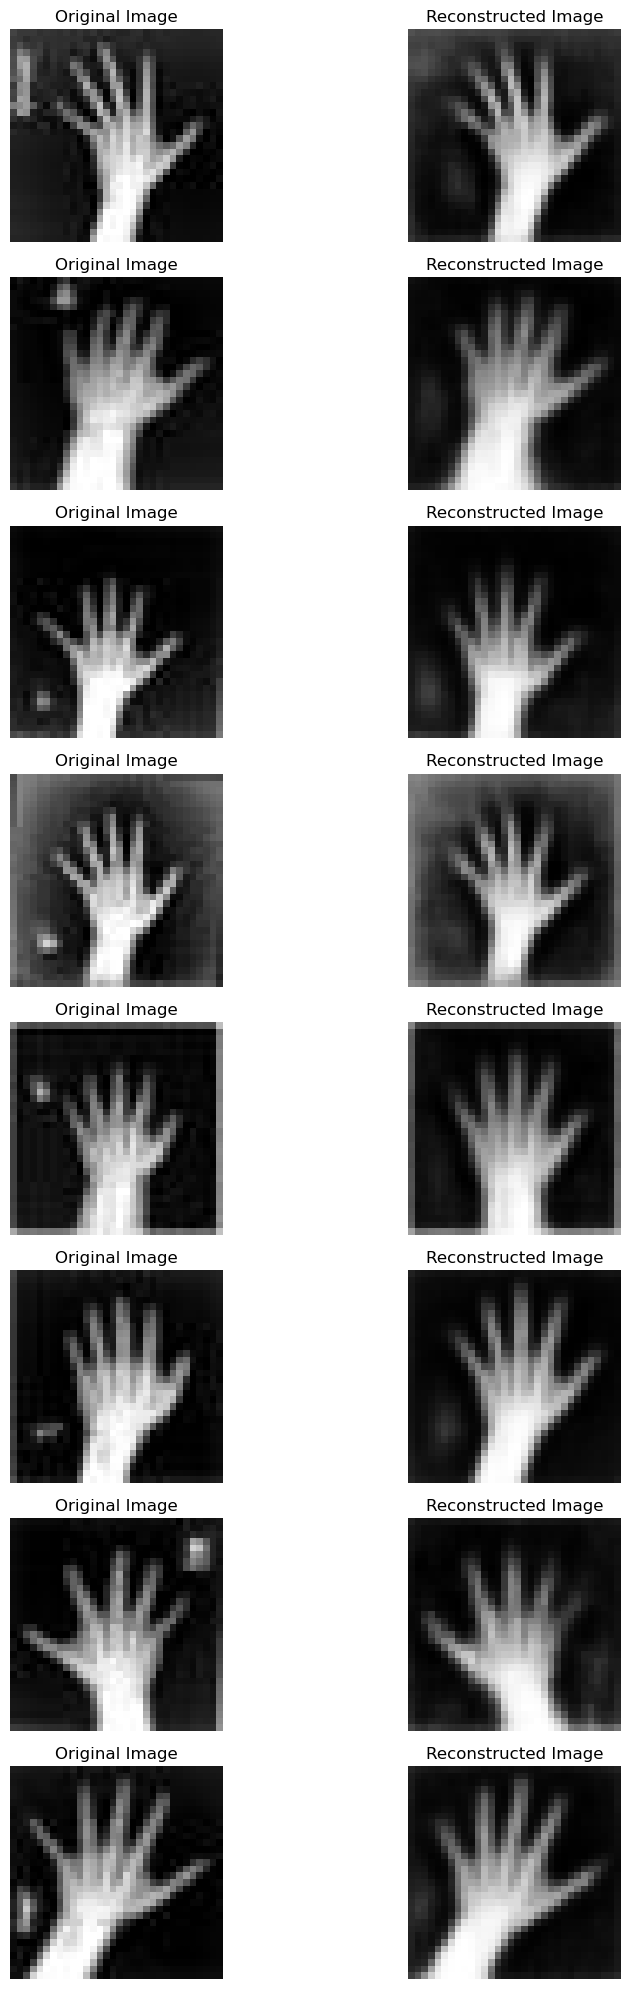

In [5]:
vae.eval()  # Set the model to evaluation mode

# Select 8 test images
test_images = next(iter(test_loader))[:8].to(device)

# Get reconstructed images
with torch.no_grad():
    reconstructed, _, _ = vae(test_images)

# Convert images to numpy for visualization
test_images = test_images.cpu().numpy()
reconstructed = reconstructed.cpu().numpy()

# Plotting
fig, axes = plt.subplots(8, 2, figsize=(10, 20))
for i in range(8):
    # Original Image
    axes[i, 0].imshow(test_images[i].squeeze(), cmap='gray')
    axes[i, 0].set_title('Original Image')
    axes[i, 0].axis('off')

    # Reconstructed Image
    axes[i, 1].imshow(reconstructed[i].squeeze(), cmap='gray')
    axes[i, 1].set_title('Reconstructed Image')
    axes[i, 1].axis('off')

plt.tight_layout()
plt.show()

### Generating New Samples
After training the VAE, the next step is to generate new samples to evaluate the model's generative capabilities. This process involves the model synthesizing new data that it has not encountered during training, demonstrating its understanding of the underlying data distribution.

#### Visualization of Generated Images
Visualizing the generated images gives an intuitive understanding of the variety and quality of the output from the VAE. This step is crucial in assessing the model's practical effectiveness in generating realistic X-ray hand images.

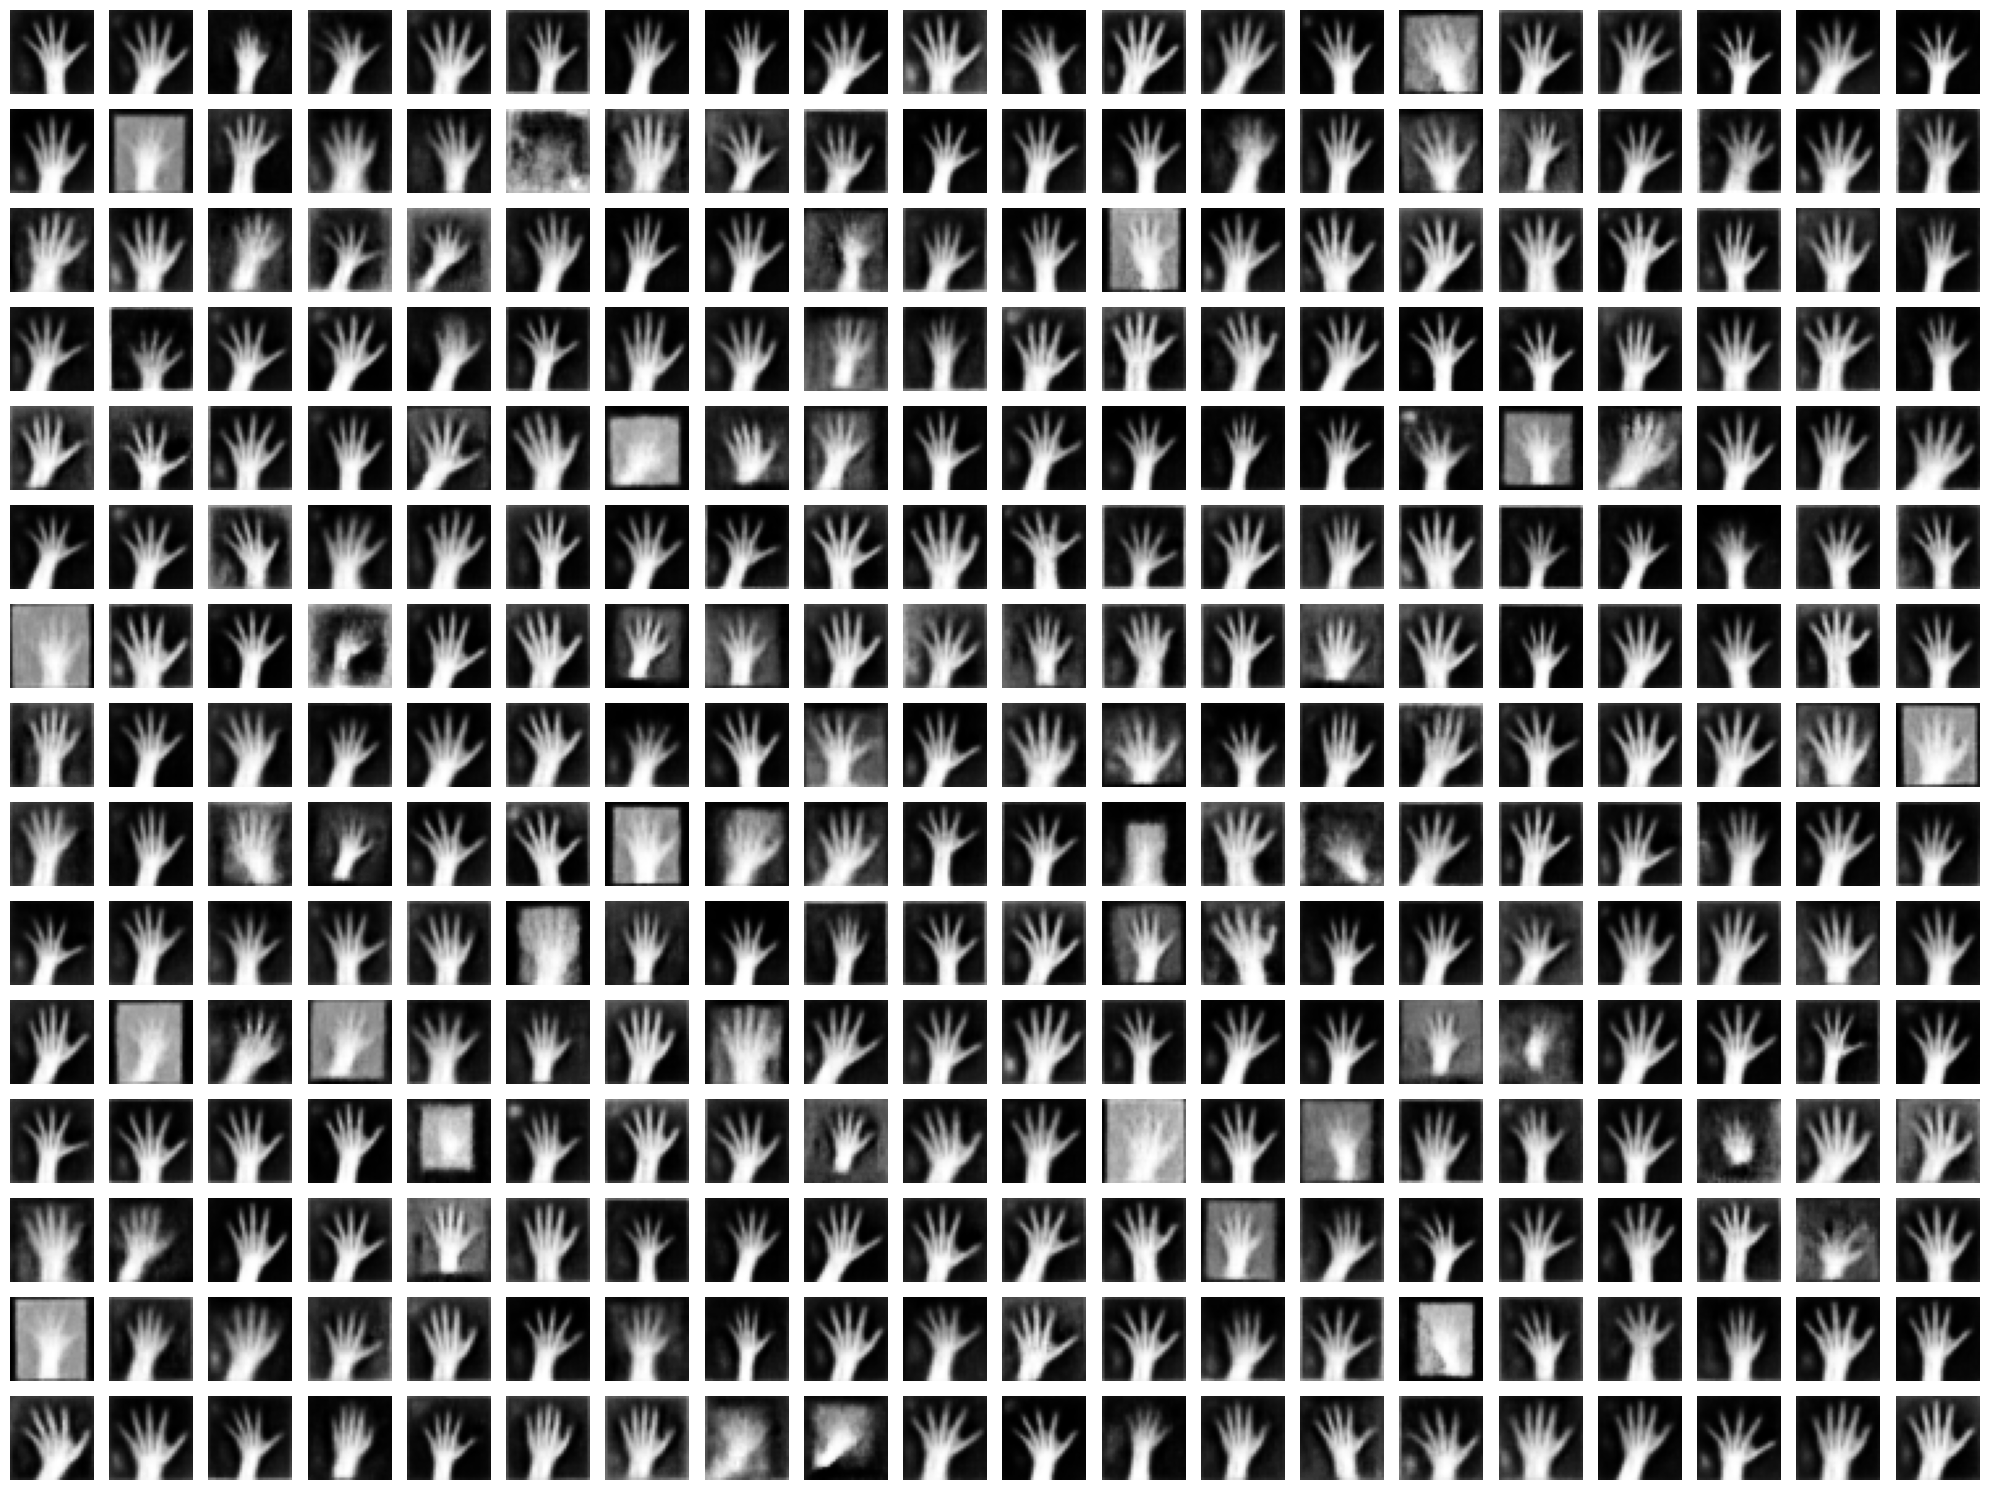

In [6]:

def generate_images(num_samples=300, latent_dim=128):
    vae.eval()
    with torch.no_grad():
        # Sample from standard normal distribution
        z = torch.randn(num_samples, latent_dim).to(device)
        samples = vae.decode(z).cpu()

        # Postprocess samples if necessary (e.g., un-normalize)
        samples = (samples + 1) / 2  # Rescale images from [-1, 1] to [0, 1]
        return samples

generated_images = generate_images()

# Visualizing 300 generated images
import matplotlib.pyplot as plt

fig, ax = plt.subplots(nrows=15, ncols=20, figsize=(20, 15))
for i in range(15):
    for j in range(20):
        ax[i, j].imshow(generated_images[i * 20 + j].squeeze(), cmap='gray')
        ax[i, j].axis('off')
plt.tight_layout()
plt.show()

#### Saving Generated Samples
Finally, we save these generated samples for further analysis or use in other applications. The images are saved in JPEG format, with a consistent naming convention for easy reference.

In [7]:
save_dir = './data/VAE_hands'
if not os.path.exists(save_dir):
    os.makedirs(save_dir)

In [8]:
for i, image in enumerate(generated_images):
    save_path = os.path.join(save_dir, f'VAE_hands{i+1}.png')
    plt.imsave(save_path, image.squeeze(), cmap='gray')

### Saving the model

In [9]:
# saving the model
# Define the path for saving the model
model_save_path = "../model/my_vae_model.pth"

# Create the models directory if it doesn't exist
os.makedirs(os.path.dirname(model_save_path), exist_ok=True)

# Save the model's state dictionary
torch.save(vae.state_dict(), model_save_path)